# **Libraries and Dependencies**

In [1]:
! pip install pyDOE2 #Latin Hypercube Sampling
! pip install plotting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25537 sha256=f13a80200332c10b817176570a53eaf7249ff7f9d324053706974c7d79af6403
  Stored in directory: /root/.cache/pip/wheels/a7/56/10/2dcc175569666fb8af5c210980eb5833befd399780e71e6749
Successfully built pyDOE2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE2 import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

In [4]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# **Physics-informed Neural Networks**

In [5]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer = torch.nn.Linear(layers[i], layers[i+1])
            torch.nn.init.xavier_normal_(layer.weight.data, gain=1.0)
            torch.nn.init.zeros_(layer.bias.data)

            layer_list.append(
                ('layer_%d' % i, layer)
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            # layer_list.append(('dropout_%d'%i, torch.nn.Dropout(0.005)))

            # layer_list.append(('normalisation_%d' % i, torch.nn.BatchNorm1d(layers[i+1])))
            # layer_list.append(('normalisation_%d' % i, torch.nn.layerNorm(layers[i+1])))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out


In [6]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu, X_star, temperature):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        self.nu = X_u.shape[0]
        self.nf = X_f.shape[0]

        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        # # grid points
        self.num_x = 256
        self.num_t = 100
        self.build_grid()

        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=20, 
            max_eval=20, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )


        self.num_epochs = 400
        
        self.iter = 0
        self.temperature = temperature
        self.set_adaptive_col_params()

        #random seeds
        self.lhs_rs = 0
        torch.manual_seed(0)
        np.random.seed(1234)

    def build_grid(self):
        grid_x = np.zeros(shape=(1, self.num_x))
        grid_x[0] = lb[0] + ((ub[0]-lb[0])/(self.num_x - 1))*np.arange(self.num_x)
        grid_t = np.zeros(shape=(1, self.num_t))
        grid_t[0] = lb[1] + ((ub[1]-lb[1])/(self.num_t - 1))*np.arange(self.num_t)

        gX, gT = np.meshgrid(grid_x, grid_t)
        G = np.hstack((gX.flatten()[:,None], gT.flatten()[:,None]))

        self.grid_x = torch.tensor(G[:, 0:1], requires_grad=True).float().to(device)
        self.grid_t = torch.tensor(G[:, 1:2], requires_grad=True).float().to(device)      

    def set_adaptive_col_params(self):
        self.proxy = "adapt-r"
        self.gamma = 0.0
        self.T = 50
        self.temperature = self.temperature
        self.e = 2

    def net_u(self, x, t):
        X = torch.cat([x, t], dim=1)

        # X = torch.tensor([x, t], requires_grad=True).float().to(device)
        # X = torch.tensor([-0.5, 0.5], requires_grad=True).float().to(device)

        u = self.dnn(X)
        return u

    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]

        u_tt = torch.autograd.grad(
            u_t, t, 
            grad_outputs=torch.ones_like(u_t),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]
        
        f = u_xx + u_tt - torch.exp(-x)*(x - 2 + t**3 + 6*t)

        return f
    
    def grad_value(self, x, t):
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]
        
        grad_tensor = torch.sqrt(torch.square(u_x) + torch.square(u_t))
        
        return grad_tensor

    def proxy_func(self):
        prob = np.zeros(shape=(self.num_x, self.num_t))

        start = time.time()
        
        if self.proxy == 'adapt-r':
            prob_proxy = self.net_f(self.grid_x, self.grid_t)
        elif self.proxy == 'adapt-g':
            prob_proxy = self.grad_value(self.grid_x, self.grid_t)

        prob_proxy = abs(prob_proxy)
        max_value = prob_proxy.max()
        print('iter: {} | max value in prob: {}'.format(self.iter, max_value))
        prob_proxy = torch.sub(prob_proxy, max_value)
        prob_proxy = torch.exp(prob_proxy/self.temperature)
        prob = np.transpose(np.reshape(prob_proxy.cpu().detach().numpy(), (self.num_t, self.num_x)))

        return prob/prob.sum()

    def sample_uniform(self, size):
        
        x_f_train1 = self.lb[0].item() + (self.ub[0].item() - self.lb[0].item())*lhs(1, size, random_state=self.lhs_rs)
        t_f_train1 = self.lb[1].item() + (self.ub[1].item() - self.lb[1].item())*lhs(1, size)

        return x_f_train1, t_f_train1
    
    def sample_proxy(self, size):
        
        # normalise the array again
        self.prob /= self.prob.sum()
        flat = self.prob.flatten()

        x_f_train2 = np.zeros(shape=(size, 1))
        t_f_train2 = np.zeros(shape=(size, 1))

        for s in range(size):
            sample_index = np.random.choice(a=flat.size, p=flat)
            index = np.unravel_index(sample_index, self.prob.shape)

            x = self.lb[0] + (self.ub[0] - self.lb[0]) * index[0] / (self.num_x)
            t = self.lb[1] + (self.ub[1] - self.lb[1]) * index[1] / (self.num_t)

            x_f_train2[s][0] = x
            t_f_train2[s][0] = t

        return x_f_train2, t_f_train2

    def loss_func(self):

        global train_error
        
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)

        self.loss_u = torch.mean((self.u - u_pred) ** 2)
        self.loss_f = torch.mean(f_pred ** 2)
        
        loss = self.loss_u + self.loss_f
        
        loss.backward()

        self.iter += 1
        # if self.iter % 100 == 0:
        print(
            'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), self.loss_u.item(), self.loss_f.item())
        )
        
        train_error.append(loss.item())

        return loss
    
    def adaptive_train(self):
        # set the model training mode "on"
        self.dnn.train()

        self.prob = np.ones(shape=(self.num_x, self.num_t)) / (self.num_x * self.num_t)

        for epoch_index in range(self.num_epochs):
            print(f"epoch: {epoch_index} | iter: {self.iter}")
            print(f"calculating probablities")
            new_prob = self.proxy_func()
            self.prob = new_prob + self.gamma * self.prob
            self.prob /= self.prob.sum()

            if epoch_index % self.e == 0:

                # cosine annealing
                self.Tc = epoch_index % self.T
                self.eta = 1/2 * (1 + np.cos(np.pi * self.Tc/self.T))

                x_f1, t_f1 = self.sample_uniform(int(self.eta * self.nf))
                x_f2, t_f2 = self.sample_proxy(int((1-self.eta)*self.nf))

                self.x_f = np.concatenate((x_f1, x_f2), axis=0)
                self.t_f = np.concatenate((t_f1, t_f2), axis=0)

                self.x_f = torch.tensor(self.x_f, requires_grad=True).float().to(device)
                self.t_f = torch.tensor(self.t_f, requires_grad=True).float().to(device)

                # # gibbs annealing
                # if epoch_index > int(0.2*self.num_epochs) and self.temperature > 20:
                #   self.temperature = 0.99 * self.temperature

                # x_f2, t_f2 = self.sample_proxy(int((self.nf)))

                # self.x_f = torch.tensor(x_f2, requires_grad=True).float().to(device)
                # self.t_f = torch.tensor(t_f2, requires_grad=True).float().to(device)

            # Backward and optimize
            self.optimizer.step(self.loss_func)
            
            # # get a test error
            # global test_error
            # u_pred, f_pred = model.predict(X_star)

            # error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
            # test_error.append(error_u)
        
        return None
    
    def vanilla_train(self):
        # set the model training mode "on"
        self.dnn.train()

        for epoch_index in range(self.num_epochs):
            self.optimizer.step(self.loss_func)
    
            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

# **Configurations**

In [7]:
nu = 0.01/np.pi
noise = 0.0        

train_error = []
test_error = []

N_u = 100
N_f = 10000
n_neurs = 15
layers = [2, n_neurs, n_neurs, n_neurs, n_neurs, n_neurs, n_neurs, 1]

data = scipy.io.loadmat('/content/drive/MyDrive/SEM - 7/BTP/Phase-2/data/test_data.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

print("type of t: {} || shape: {}".format(type(t), t.shape))

Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)
print("type of X: {} || shape: {}".format(type(X), X.shape))
print("type of T: {} || shape: {}".format(type(T), T.shape))

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
print("type of X_star: {} || shape: {}".format(type(X_star), X_star.shape))

u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)
mu = X_star.mean()
var = X_star.var()    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])

X_f_train = lb + (ub-lb)*lhs(2, N_f)
# X_f_train = (lhs(2, N_f) - mu) / var

X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

#u_pred, f_pred = model.predict(X_star)

#error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#print('Error u: %e' % (error_u))                     

#U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
#Error = np.abs(Exact - U_pred)

type of t: <class 'numpy.ndarray'> || shape: (256, 1)
type of X: <class 'numpy.ndarray'> || shape: (256, 256)
type of T: <class 'numpy.ndarray'> || shape: (256, 256)
type of X_star: <class 'numpy.ndarray'> || shape: (65536, 2)


# **Training**

In [8]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, temperature=50000)

In [9]:
%%time

model.vanilla_train()

Iter 1, Loss: 3.02470e+00, Loss_u: 1.83957e-01, Loss_f: 2.84074e+00
Iter 2, Loss: 2.86913e+00, Loss_u: 1.84741e-01, Loss_f: 2.68439e+00
Iter 3, Loss: 2.05952e+00, Loss_u: 1.82473e-01, Loss_f: 1.87704e+00
Iter 4, Loss: 8.75316e+01, Loss_u: 3.88919e+00, Loss_f: 8.36424e+01
Iter 5, Loss: 1.21239e+00, Loss_u: 2.60572e-01, Loss_f: 9.51815e-01
Iter 6, Loss: 6.46032e+00, Loss_u: 1.36266e+00, Loss_f: 5.09766e+00
Iter 7, Loss: 1.10598e+00, Loss_u: 3.01910e-01, Loss_f: 8.04070e-01
Iter 8, Loss: 1.04486e+00, Loss_u: 2.97178e-01, Loss_f: 7.47683e-01
Iter 9, Loss: 9.75716e-01, Loss_u: 3.18036e-01, Loss_f: 6.57680e-01
Iter 10, Loss: 8.54496e-01, Loss_u: 3.60543e-01, Loss_f: 4.93953e-01
Iter 11, Loss: 7.66558e-01, Loss_u: 3.68688e-01, Loss_f: 3.97870e-01
Iter 12, Loss: 7.10048e-01, Loss_u: 3.55044e-01, Loss_f: 3.55005e-01
Iter 13, Loss: 6.77758e-01, Loss_u: 3.53844e-01, Loss_f: 3.23914e-01
Iter 14, Loss: 6.04706e-01, Loss_u: 3.52871e-01, Loss_f: 2.51835e-01
Iter 15, Loss: 5.73134e-01, Loss_u: 3.42459

In [10]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 1.627832e-02


In [11]:
x_man = torch.tensor([[0,0]]).float().to(device)
u_man, f_man = model.predict(x_man)
u_pred_man = 0

print(u_man)

[[0.00077787]]


<ipython-input-6-f7bf2173af10>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
<ipython-input-6-f7bf2173af10>:277: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)


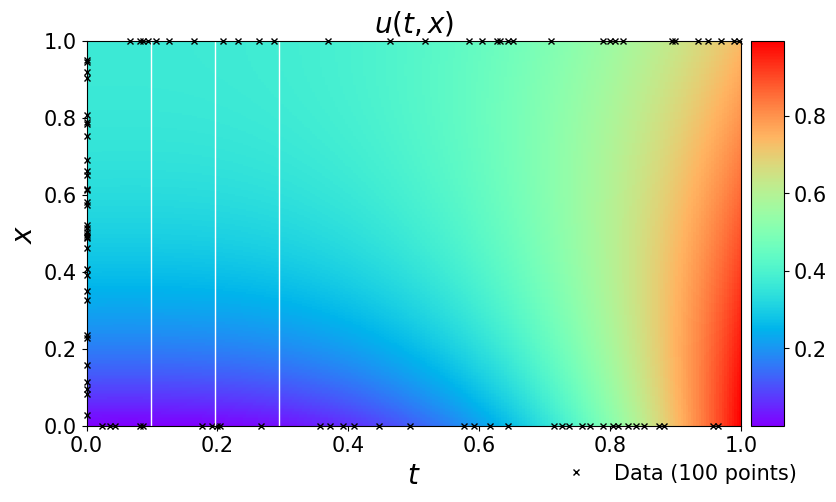

In [12]:
""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

# **Visualizations**

<ipython-input-13-b5bac6619e2f>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[0, 0])


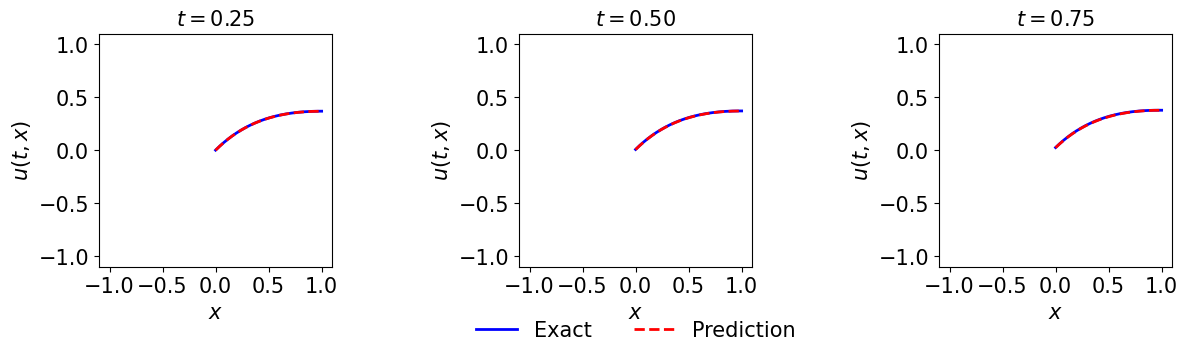

In [13]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

Text(0.5, 1.0, 'train_error error')

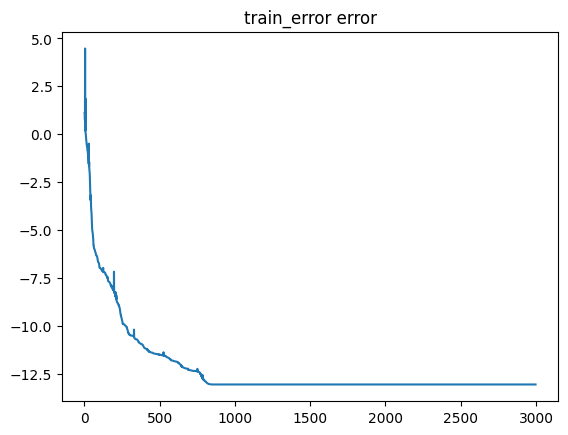

In [14]:
import matplotlib

x_axis = [i for i in range(1,len(train_error)+1)]

new_train_error = np.log(train_error)
plt.plot(x_axis, new_train_error)
# plt.ylim(1e-4, 1)
plt.title("train_error error")

Text(0.5, 1.0, 'collocation points: 10000- vanilla')

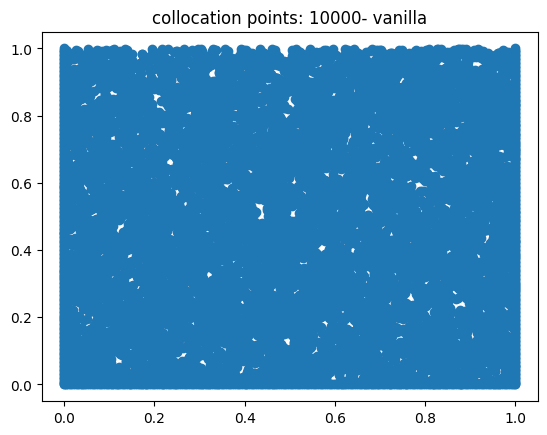

In [15]:
x_col = model.x_f.detach().cpu().numpy()
t_col = model.t_f.detach().cpu().numpy()

plt.scatter(x_col, t_col)
plt.title("collocation points: {}- vanilla".format(N_f))